In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import urllib.request

import warnings
warnings.filterwarnings('ignore')
print(np.__version__)

1.25.2


In [ ]:
pip uninstall numpy


In [27]:
import numpy
print(numpy.__version__)

1.20.3


In [3]:
# tensorflow libraries/dependencies
import tensorflow as tf
from tensorflow import keras
## preprocessing
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img 

# models, layers, metrics, optimizers and callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## pre-trained models
from tensorflow.keras.applications import InceptionResNetV2,InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.xception import Xception

print(f"Tensorflow Version: {tf.__version__}")
print(f"Number of GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

Tensorflow Version: 2.13.0
Number of GPUs Available: 0


In [4]:
# set constants
SIZE = (224,224)
BATCH_SIZE = 42
SEED = 42
labels = pd.read_csv('labels.csv')
labels['id'] = labels['id'].apply(lambda x: x + '.jpg')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


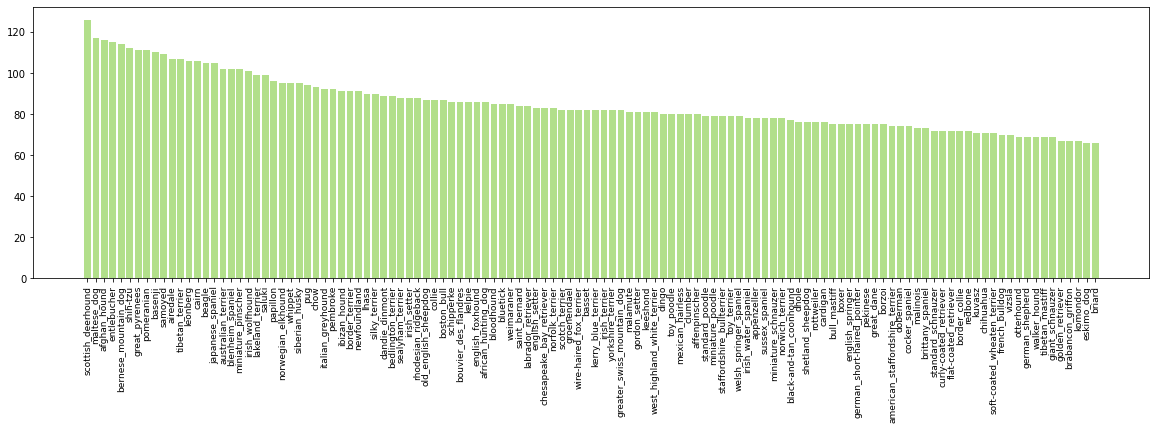

In [5]:
d = labels.breed.value_counts()
plt.figure(figsize=(20,5))
plt.bar(d.index,d.values,color=plt.cm.Paired([2]))
plt.xticks(rotation=90, fontsize=9)
plt.show()

In [6]:
# ImageDatagenerator to load the images in batches and perform data augmentation

data_generator = ImageDataGenerator(rescale= 1./255, validation_split=0.3, rotation_range=20,
                                    zoom_range=0.1, width_shift_range=0.2, height_shift_range=0.2,
                                    shear_range=0.1, horizontal_flip=True, fill_mode="nearest")

INPUT_DIR = 'C:/Users/randy/Desktop/dl/train'

In [7]:
train_data = data_generator.flow_from_dataframe(dataframe=labels, directory=INPUT_DIR, x_col='id', y_col='breed', 
                                                target_size=SIZE, batch_size=BATCH_SIZE, seed=SEED, shuffle=True, 
                                                class_mode='categorical',subset='training', random_state=1)

val_data = data_generator.flow_from_dataframe(dataframe=labels, directory=INPUT_DIR, x_col='id', y_col='breed', 
                                              target_size=SIZE, batch_size=BATCH_SIZE, seed=SEED, shuffle=True, 
                                              class_mode='categorical', subset='validation', random_state=1)


Found 7156 validated image filenames belonging to 120 classes.
Found 3066 validated image filenames belonging to 120 classes.


In [8]:
label_mapper = np.asarray(list(train_data.class_indices.keys()))
label_mapper

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

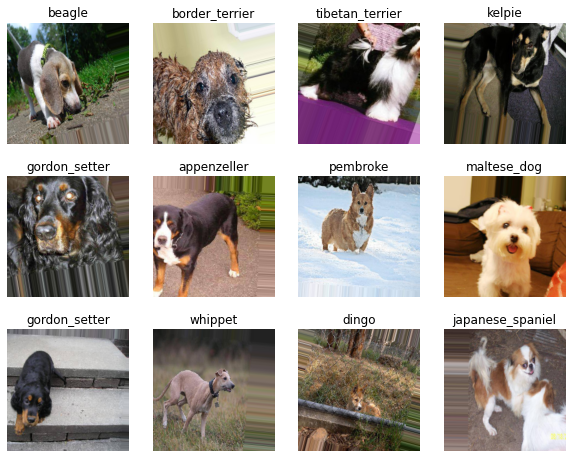

In [9]:
# display data
img,label = next(train_data)
plt.subplots(3,4,figsize=(10,8))
for i in range(1,13):
    plt.subplot(3,4,i)
    plt.imshow(img[i])
    plt.axis('off')
    idx = label[i].argmax()
    plt.title(label_mapper[idx])

In [10]:
base_model = Xception(weights='imagenet', include_top=False, classes=120)

In [11]:
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(120, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001, ), loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, None, None, 2048   20861480  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
Total params: 21107360 (80.52 MB)
Trainable params: 245880 (960.47 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [12]:
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=4, min_delta=0.01)
checkpoint = ModelCheckpoint(filepath='/kaggle/working/model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [13]:
logs = model.fit(train_data, validation_data=val_data,
                steps_per_epoch = train_data.samples//BATCH_SIZE,
                validation_steps = val_data.samples//BATCH_SIZE,
                epochs=10, verbose=1, callbacks=[checkpoint,es])

Epoch 1/10
170/170 [==============================] - ETA: 0s - loss: 1.8256 - accuracy: 0.5769
Epoch 1: val_accuracy improved from -inf to 0.70874, saving model to /kaggle/working\model.h5
170/170 [==============================] - 582s 3s/step - loss: 1.8256 - accuracy: 0.5769 - val_loss: 1.0367 - val_accuracy: 0.7087
Epoch 2/10
170/170 [==============================] - ETA: 0s - loss: 0.8654 - accuracy: 0.7546 
Epoch 2: val_accuracy improved from 0.70874 to 0.73157, saving model to /kaggle/working\model.h5
170/170 [==============================] - 5030s 30s/step - loss: 0.8654 - accuracy: 0.7546 - val_loss: 0.9504 - val_accuracy: 0.7316
Epoch 3/10
170/170 [==============================] - ETA: 0s - loss: 0.7524 - accuracy: 0.7713
Epoch 3: val_accuracy improved from 0.73157 to 0.73581, saving model to /kaggle/working\model.h5
170/170 [==============================] - 577s 3s/step - loss: 0.7524 - accuracy: 0.7713 - val_loss: 0.9248 - val_accuracy: 0.7358
Epoch 4/10
170/170 [=====

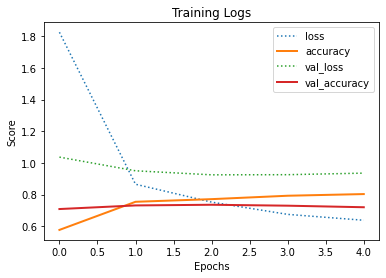

In [14]:
plt.plot(logs.history['loss'], label='loss', linestyle='dotted')
plt.plot(logs.history['accuracy'], label='accuracy', linewidth=2)
plt.plot(logs.history['val_loss'], label='val_loss', linestyle='dotted')
plt.plot(logs.history['val_accuracy'], label='val_accuracy', linewidth=2)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Training Logs')
plt.show()

In [ ]:
saved_model = keras.models.load_model('C:/Users/randy/Desktop/dl/model.h5')
saved_model.evaluate(val_data)

In [15]:
model.save('C:/Users/randy/Desktop/dl/model.h5')